### Convolution AutoEncoder

Step1: Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

Step2: Select Device

In [3]:
cuda = True
device = torch.device("cuda" if cuda else "cpu")
print(f"Using {device} device")

Using cuda device


Step3: Defining Parameters

In [16]:
num_epochs = 10
batch_size = 128 #32, 64, 128
learning_rate = 0.001

Step4: Download and Load Dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Step5: Check the Number of Images of Training and Test Images

In [6]:
print("Training Images", len(train_dataset))
print("Testing Images", len(test_dataset))

Training Images 50000
Testing Images 10000


Step6: Display Some CIFAR Dataset Images

Files already downloaded and verified


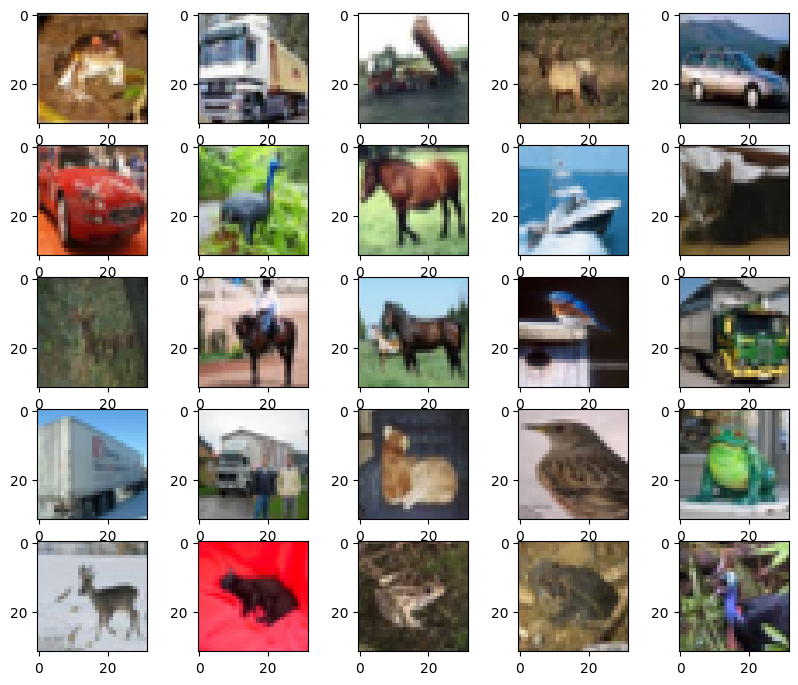

In [7]:
def show_images(dataset, num_samples=25, cols=5):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10,10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])


data = torchvision.datasets.CIFAR10(root="./data", download=True)
show_images(data)

Step7: Defining AutoEncoder Neural Network

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2)        
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.ConvTranspose2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU()

        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): ConvTranspose2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
  )
)


In [10]:
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 32, 32)) #change image size 32x32 (32, 3, 32, 32) to 64x64 (32, 3, 64, 64) will not effect Parameters (Total Weights), Calculation of weights -> in_channels * out_channels * kernel size + bias 3 *32 * 5 *5 + 32 = 2432


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [64, 3, 32, 32]           --
├─Sequential: 1-1                        [64, 3, 16, 16]           --
│    └─Conv2d: 2-1                       [64, 32, 32, 32]          2,432
│    └─ReLU: 2-2                         [64, 32, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 3, 32, 32]           2,403
│    └─ReLU: 2-4                         [64, 3, 32, 32]           --
│    └─AvgPool2d: 2-5                    [64, 3, 16, 16]           --
├─Sequential: 1-2                        [64, 3, 32, 32]           --
│    └─Upsample: 2-6                     [64, 3, 32, 32]           --
│    └─ConvTranspose2d: 2-7              [64, 32, 32, 32]          2,432
│    └─ReLU: 2-8                         [64, 32, 32, 32]          --
│    └─ConvTranspose2d: 2-9              [64, 3, 32, 32]           2,403
│    └─ReLU: 2-10                        [64, 3, 32, 32]           --
Tot

Step8: Loss Function and Optimizer

In [11]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Step9: Defining Training and Testing

In [12]:
def train(net, trainloader, num_epochs):
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0
        for train_data in trainloader:
            train_inputs, _ = train_data #no need for the labels
            train_inputs = train_inputs.to(device)
            optimizer.zero_grad()
            train_outputs = net(train_inputs)
            train_loss = criterion(train_outputs, train_inputs)
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()

        total_loss = running_loss / len(trainloader)
        
        train_losses.append(total_loss)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {total_loss:.4f}")

    sampled_train_input = train_inputs[0:1:,:,:,:]
    sampled_train_output = train_outputs[0:1:,:,:,:]
    save_image(sampled_train_input, 'trainimagebeforeencoder.png')
    save_image(sampled_train_output, 'trainimageafterencoder.png')
    return train_losses

def test(net, testloader):
    for test_data in testloader:
        test_inputs, _ = test_data # no need for the labels
        test_inputs = test_inputs.to(device)
        test_outputs = net(test_inputs)
        
        sampled_test_input = test_inputs[0:1,:,:,:]
        sampled_test_output = test_outputs[0:1:,:,:,:]    
        save_image(sampled_test_input, 'testimagebeforeencoder.png')
        save_image(sampled_test_output, 'testimageafterencoder.png')
        break    

Step10: Model Training

Epoch [1/10] Train Loss: 0.0028
Epoch [2/10] Train Loss: 0.0028
Epoch [3/10] Train Loss: 0.0028
Epoch [4/10] Train Loss: 0.0028
Epoch [5/10] Train Loss: 0.0027
Epoch [6/10] Train Loss: 0.0027
Epoch [7/10] Train Loss: 0.0027
Epoch [8/10] Train Loss: 0.0027
Epoch [9/10] Train Loss: 0.0027
Epoch [10/10] Train Loss: 0.0027


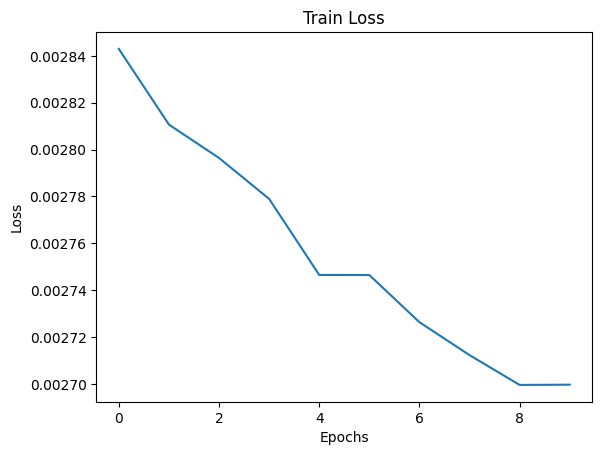

In [17]:
model.to(device)
train_losses = train(model, train_loader, num_epochs)
plt.figure()
plt.plot(train_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('trainloss.png')
test(model, test_loader)

Step11: Plotting Training Images (Ground Truth VS Reconstructed)

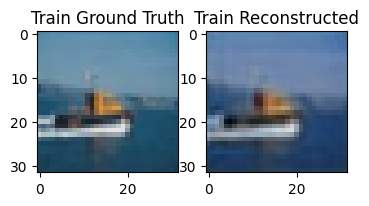

In [18]:
import matplotlib.image as mpimg
plt.figure(figsize=(4,4))
img1 = mpimg.imread("/home/taha/Taha26/Pytorchtutorial/aept_tf/trainimagebeforeencoder.png")
img2 = mpimg.imread("/home/taha/Taha26/Pytorchtutorial/aept_tf/trainimageafterencoder.png")
plt.subplot(1,2,1).set_title("Train Ground Truth")
plt.imshow(img1)
plt.subplot(1,2,2).set_title("Train Reconstructed")
plt.imshow(img2)
plt.show()

Step12: Plotting Testing Images (Ground Truth VS Reconstructed)

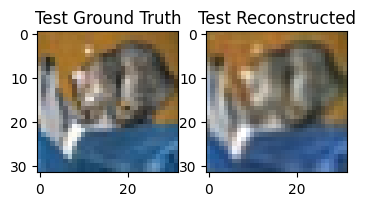

In [19]:
plt.figure(figsize=(4,4))
img3 = mpimg.imread("/home/taha/Taha26/Pytorchtutorial/aept_tf/testimagebeforeencoder.png")
img4 = mpimg.imread("/home/taha/Taha26/Pytorchtutorial/aept_tf/testimageafterencoder.png")
plt.subplot(1,2,1).set_title("Test Ground Truth")
plt.imshow(img3)
plt.subplot(1,2,2).set_title("Test Reconstructed")
plt.imshow(img4)
plt.show()